In [1]:
# Deep learning framework
import keras
print(keras.__version__)
# Implements TensorFlow on GPU (hence older version)
import tensorflow as tf
print(tf.__version__)
# Data importing
import pandas as pd
print(pd.__version__)
# Matrix and numerical functions
import numpy as np
print(np.__version__)
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Serializing objects
import pickle
# Serializing trained models
import h5py
# Printing readable results
from prettytable import PrettyTable

# Various Keras tools
from keras.models import Model, Sequential, model_from_json
from keras import layers, regularizers, Input, Model, callbacks
from keras.optimizers import RMSprop, Adam, Nadam
from keras.utils import plot_model
# Have to use K.clear_session() for TensorBoard to work
from keras import backend as K

Using TensorFlow backend.


2.1.3
1.1.0
0.22.0
1.12.1


## Import helper functions

In [2]:
from generator import *

In [3]:
# Use seaborn graphical settings, which are much prettier
sns.set()
# Scale widths, fonts, etc. to fit well in a paper (an alternative would be "notebook")
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

### Train/validation/test data standardized by training data parameters

In [4]:
# Load prepared csv's from data_intake
df2n = np.loadtxt('data/standardized_complete.csv', delimiter = ',', skiprows = 1)
df2n_train = np.loadtxt('data/standardized_train.csv', delimiter = ',', skiprows = 1)
df2n_valid = np.loadtxt('data/standardized_valid.csv', delimiter = ',', skiprows = 1)
df2n_test = np.loadtxt('data/standardized_test.csv', delimiter = ',', skiprows = 1)

train_size = df2n_train.shape[0]
valid_size = df2n_valid.shape[0]
test_size = df2n_test.shape[0]

print(df2n.shape)
print(df2n_train.shape)
print(df2n_valid.shape)
print(df2n_test.shape)

# Load helper metadata
headers = pickle.load(open('Data/headers', 'rb'))
means = pickle.load(open('Data/means', 'rb'))
stdevs = pickle.load(open('Data/stdevs', 'rb'))

(53400, 329)
(35880, 329)
(8760, 329)
(8760, 329)


## Function to evaluate an architecture
Parameters (in order):
- Function to generate models
- Input layer tensor object
- k number of models to generate and evaluate
- Number of epochs
- ce_k number of checkpoints to use for checkpoint ensembling
- Plotting y axis limits (low, high) --> from experimentation
- Folder path to store objects of the models. Numbered sub-folders must alreday exist.
- Training set generator and number of steps
- Validation (test) set generator and numbers of steps
- Vector of variable standard deviations (from when the training set was standardized)

Returns:
- The k trained models
- The corresponding k training histories
- Lists of the MAEs, RMSEs, and Checkpoint Ensembled MAEs and RMSEs for each model

In [25]:
def load_model(model_function, input_layer, sorted_epoch_num, path, modelnum):
    if(sorted_epoch_num < 10):
        epoch = '0'+str(sorted_epoch_num)
    else:
        epoch = str(sorted_epoch_num)
    
    loaded_model = model_function(input_layer)
    loaded_model.load_weights(path+modelnum+'/weights_'+epoch+'.h5')
    return loaded_model

def evaluate_mlp(model_function, input_layer, train_gen, train_steps, stdevs, val_gen, val_steps,
                 test_gen, test_steps, path, k = 5, epochs = 100, ce_k = 5, ylim = (2, 4.5)):
    models = []
    histories = []
    val_maes = []
    val_rmses = []
    val_ce_maes = []
    val_ce_rmses = []
    val_ranked_epochs = []
    test_ce_maes = []
    test_ce_rmses = []
    
    
    for i in range(k):
        print('\nTraining model #', str(i+1))
        model = model_function(input_layer)
        model.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath = path+str(i+1)+'/weights_{epoch:02d}.h5',
                monitor = 'val_loss', mode = 'min', save_weights_only = True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor = 'loss', factor = 0.5, patience = 5, verbose = 1
            )
        ]

        history = model.fit_generator(train_gen, 
                                      steps_per_epoch=train_steps, 
                                      epochs=epochs, 
                                      validation_data=val_gen, 
                                      validation_steps=val_steps,
                                      verbose = 1,
                                      callbacks = callbacks)
        models.append(model)
        histories.append(history)
        
        print('Saving model topology and training history plots.')
        plot_model(model, show_shapes = True, to_file = path+str(i+1)+'/topology.pdf')
        with open(path+str(i+1)+'/model.json', 'w') as json_file:
            json_file.write(model.to_json())
            
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        rmse = np.sqrt(history.history['mean_squared_error'])
        val_rmse = np.sqrt(history.history['val_mean_squared_error'])
        
        sorted_epochs = np.add(np.argsort(val_loss), 1)
        val_ranked_epochs.append(sorted_epochs)
        pickle.dump(sorted_epochs, open(path+str(i+1)+'/sorted_epochs', 'wb'))

        plt.figure()
        plt.plot(range(len(loss)), np.multiply(loss, stdevs[0]), 'b', color = 'grey', label='Training loss')
        plt.plot(range(len(loss)), np.multiply(val_loss, stdevs[0]), 'b', color = 'blue', label='Validation loss')
        plt.ylim(ylim)
        plt.xlabel('Epoch')
        plt.ylabel('MAE (€)')
        plt.legend(frameon = True, framealpha = 1)
        plt.savefig(path+str(i+1)+'/training.pdf', bbox_inches = 'tight')
        plt.show()

        min_index = np.argmin(val_loss)
        #print('Min. MAE  €:', val_loss[min_index]*stdevs[0])
        val_maes.append(val_loss[min_index])
        #print('Ass. RMSE €:', val_rmse[min_index]*stdevs[0])
        val_rmses.append(val_rmse[min_index])
        
        print('Checkpoint Ensembling')
        # Checkpoint Ensembling
        ce_models = []
        for j in range(ce_k):
            ce_model = load_model(model_function, input_layer, sorted_epochs[j], path, str(i+1))
            ce_models.append(ce_model)
        outputs = [model.outputs[0] for model in ce_models]
        output_layer = layers.average(outputs)
        checkpoint_ensemble = Model(input_layer, output_layer)
        checkpoint_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        
        val_ce_score = checkpoint_ensemble.evaluate_generator(val_gen, val_steps)
        #print('CE MAE  €:', val_ce_score[0]*stdevs[0])
        val_ce_maes.append(val_ce_score[0])
        #print('CE RMSE €:', np.sqrt(val_ce_score[1])*stdevs[0])
        val_ce_rmses.append(np.sqrt(val_ce_score[1]))
        
        test_ce_score = checkpoint_ensemble.evaluate_generator(test_gen, test_steps)
        #print('CE MAE  €:', test_ce_score[0]*stdevs[0])
        test_ce_maes.append(test_ce_score[0])
        #print('CE RMSE €:', np.sqrt(test_ce_score[1])*stdevs[0])
        test_ce_rmses.append(np.sqrt(test_ce_score[1]))
        
    return_dict = {
        "models": models,
        "histories": histories,
        "val_maes": val_maes,
        "val_rmses": val_rmses,
        "val_ce_maes": val_ce_maes,
        "val_ce_rmses": val_ce_rmses,
        "val_ranked_epochs": val_ranked_epochs,
        "test_ce_maes": test_ce_maes,
        "test_ce_rmses": test_ce_rmses
    }
        
    return return_dict
        
# Calculates the validation and test metrics for the best models, checkpoint ensembled, and ensembling across the best models
# Prints the results as output and saves the corresponding targets and predictions as csv files
# Requirements of defined variables in session: 
# lookback, batch_size, layer_x, val_gen, val_steps, test_gen, test_steps, means, stdevs
def evaluate_results(model_function, path):
    # Arrays to store results for each model
    ## Bit convoluted to use separate arrays, but do it to make sure there are no mistakes
    val_maes = []
    val_rmses = []
    val_ce_maes = []
    val_ce_rmses = []
    
    test_maes = []
    test_rmses = []
    test_ce_maes = []
    test_ce_rmses = []
    
    # Best epoch weights for each model, used when ensembling across
    best_weights = []
    
    # Re-initialize generators, as they will continue where they last left off otherwise
    val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
    test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
    
    # Get the models' corresponding val and test targets and save as csv in their parent directory, since same for all models
    val_targets = []
    i = 1
    for ins, outs in val_gen:
        val_targets.append(outs)
        # Stop when gotten as far as we can in validation set (from batch size and lookback) before circling around to beginning
        if i == val_steps:
            # Flatten to a 1D tensor of same shape as predictions, since currently [batches, batch_size, 1]
            val_targets = np.reshape(val_targets, (-1, 1))
            # Un-standardize the output so it's in Euros
            val_targets = np.add(np.multiply(val_targets, stdevs[0]), means[0])
            # Save the model targets in the models' parent directory
            np.savetxt(path+'/val_targets.csv', val_targets, delimiter = ',', fmt = '%f')
            # Stop iterating over the generator
            break
        # Otherwise, increment the step counter to keep track of where we are in the validation set
        i = i + 1
    
    # Repeat for test set
    test_targets = []
    i = 1
    for ins, outs in test_gen:
        test_targets.append(outs)
        if i == test_steps:
            test_targets = np.reshape(test_targets, (-1, 1))
            test_targets = np.add(np.multiply(test_targets, stdevs[0]), means[0])
            np.savetxt(path+'/test_targets.csv', test_targets, delimiter = ',', fmt = '%f')
            break
        i = i + 1
            
    # Make predictions with the five models
    ## Make predictions and calculate metrics manually so we can save the actual predictions
    for i in range(5):
        # Load list of sorted epochs to find the best one(s)
        sorted_epochs = pickle.load(open(path+str(i+1)+'/sorted_epochs', 'rb'))
        # Extract the best weights for use 
        best_weights.append(sorted_epochs[0])
        # Load model and weights, then compile with same settings
        model = load_model(model_function, layer_x, sorted_epochs[0], path, str(i+1))
        model.compile(optimizer = 'Adam', loss = 'mae', metrics = ['mse'])
        # Re-initialize generators
        val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
        test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
        # Make predictions on the validation and test sets, and store the un-standardized results
        val_preds = model.predict_generator(val_gen, val_steps)
        val_preds = np.add(np.multiply(val_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/val_predictions.csv', val_preds, delimiter = ',', fmt = '%f')
        test_preds = model.predict_generator(test_gen, test_steps)
        test_preds = np.add(np.multiply(test_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/test_predictions.csv', test_preds, delimiter = ',', fmt = '%f')
        # Evaluate on the validation and test sets and append to our lists for printing
        ## Could use model.evaluate_generator() here, but we already have the targets and predictions, so no need
        val_maes.append(np.mean(np.abs(val_targets - val_preds)))
        val_rmses.append(np.sqrt(np.mean(np.square(val_targets - val_preds))))
        test_maes.append(np.mean(np.abs(test_targets - test_preds)))
        test_rmses.append(np.sqrt(np.mean(np.square(test_targets - test_preds))))
        
        # Checkpoint Ensemble the model's best 5 weights
        ce_models = []
        # Create a model object for each of the five best weights
        for j in range(5):
            ce_models.append(load_model(model_function, layer_x, sorted_epochs[j], path, str(i+1)))
        # Gather the output tensors for the five models
        outputs = [model.outputs[0] for model in ce_models]
        # Average their predictions to do simple averaging ensembling
        output_layer = layers.average(outputs)
        # Create an ensemble model object that outputs the single averaged prediction, and compile with same settings
        checkpoint_ensemble = Model(layer_x, output_layer)
        checkpoint_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
        # Get checkpoint ensembled validation and test predictions and store un-standardized predictions as csv
        # Re-initialize generators
        val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
        test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
        val_ce_preds = checkpoint_ensemble.predict_generator(val_gen, val_steps)
        val_ce_preds = np.add(np.multiply(val_ce_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/val_ce_predictions.csv', val_ce_preds, delimiter = ',', fmt = '%f')
        test_ce_preds = checkpoint_ensemble.predict_generator(test_gen, test_steps)
        test_ce_preds = np.add(np.multiply(test_ce_preds, stdevs[0]), means[0])
        np.savetxt(path+str(i+1)+'/test_ce_predictions.csv', test_ce_preds, delimiter = ',', fmt = '%f')
        # Evaluate on validation and test sets, un-standardize, and add to our lists for printing
        val_ce_maes.append(np.mean(np.abs(val_targets - val_ce_preds)))
        val_ce_rmses.append(np.sqrt(np.mean(np.square(val_targets - val_ce_preds))))
        test_ce_maes.append(np.mean(np.abs(test_targets - test_ce_preds)))
        test_ce_rmses.append(np.sqrt(np.mean(np.square(test_targets - test_ce_preds))))
        
    # Ensemble across the best five models instead
    cross_models = []
    # Create a model object for each of the five models' best weights (lowest validation set error during training)
    for i in range(5):
        cross_models.append(load_model(model_function, layer_x, best_weights[i], path, str(i+1)))
    # Gather the five models' output, average them, and create an ensembled model object that makes a single prediction
    outputs = [model.outputs[0] for model in cross_models]
    output_layer = layers.average(outputs)
    cross_ensemble = Model(layer_x, output_layer)
    cross_ensemble.compile(optimizer = Adam(), loss = 'mae', metrics = ['mse'])
    # Make predictions on the validation and test sets, then save the un-standardized results as csv
    # Re-initialize generators
    val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
    test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)
    val_cross_preds = cross_ensemble.predict_generator(val_gen, val_steps)
    val_cross_preds = np.add(np.multiply(val_cross_preds, stdevs[0]), means[0])
    np.savetxt(path+'/val_cross_predictions.csv', val_cross_preds, delimiter = ',', fmt = '%f')
    test_cross_preds = cross_ensemble.predict_generator(test_gen, test_steps)
    test_cross_preds = np.add(np.multiply(test_cross_preds, stdevs[0]), means[0])
    np.savetxt(path+'/test_cross_predictions.csv', test_cross_preds, delimiter = ',', fmt = '%f')
    # Evaluate on validation and test, and store un-standardized metrics in our lists for printing
    val_cross_mae = np.mean(np.abs(val_targets - val_cross_preds))
    val_cross_rmse = np.sqrt(np.mean(np.square(val_targets - val_cross_preds)))
    test_cross_mae = np.mean(np.abs(test_targets - test_cross_preds))
    test_cross_rmse = np.sqrt(np.mean(np.square(test_targets - test_cross_preds)))
    
    # Create PrettyTable tables for printing
    pt_v = PrettyTable(['Model', 'Min. MAE (€)', 'Ass. RMSE (€)', 'CE MAE (€)', 'CE RMSE (€)'])
    pt_t = PrettyTable(['Model', ' MAE (€)', ' RMSE (€)', 'CE MAE (€)', 'CE RMSE (€)'])

    # Iterate over the five models
    for i in range(5):
        # Add a rows containing validation and test MAEs, RMSEs, and checkpoint ensembled MAEs and RMSEs
        pt_v.add_row([i+1,
                      "{:.4f}".format(val_maes[i]),
                      "{:.4f}".format(val_rmses[i]),
                      "{:.4f}".format(val_ce_maes[i]),
                      "{:.4f}".format(val_ce_rmses[i])])

        pt_t.add_row([i+1,
                      "{:.4f}".format(test_maes[i]),
                      "{:.4f}".format(test_rmses[i]),
                      "{:.4f}".format(test_ce_maes[i]),
                      "{:.4f}".format(test_ce_rmses[i])])
        
    # Print the validation table
    print('VALIDATION')
    print(pt_v)
    print('Ensembling across')
    # Print the results from ensembling across the five best models instead of within (i.e. checkpoint ensembling)
    print('MAE  (€):', "{:.4f}".format(val_cross_mae))
    print('RMSE (€):', "{:.4f}".format(val_cross_rmse))
    
    # Same for test
    print('\nTEST')
    print(pt_t)
    print('Ensembling across')
    print('MAE  (€):', "{:.4f}".format(test_cross_mae))
    print('RMSE (€):', "{:.4f}".format(test_cross_rmse))

# "Simple" Multi-Layered Perceptrons

## MLP 1
### Inspired by ResNets, but with batch normalization after each stack, and ReLU activation after each layer
- 12 hours
- Residual connections between stacks
- Residual connections from raw (flattened) inputs to the end of each stack
- Glorot Uniform Weight initialization
- 6x3 stacks
- Dropout after residual connections and layer output have been added together

**Define model structure**

In [7]:
def mlp_1(input_layer):
    layer_1 = layers.Flatten(input_shape = (lookback+1, df2n.shape[-1]-1))(input_layer)

    layer_2 = layers.Dense(512, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_1)
    layer_3 = layers.Dense(512, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_2)
    layer_4 = layers.Dense(512, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_3)
    layer_5 = layers.BatchNormalization()(layer_4)
    residual_1 = layers.Dense(512, use_bias = False)(layer_1)
    layer_5b = layers.add([layer_5, residual_1])
    layer_6 = layers.Dropout(0.5)(layer_5b)

    layer_7 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_6)
    layer_8 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_7)
    layer_9 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_8)
    layer_10 = layers.BatchNormalization()(layer_9)
    residual_2 = layers.Dense(256, use_bias = False)(layer_6)
    residual_2x = layers.Dense(256, use_bias = False)(layer_1)
    layer_10b = layers.add([layer_10, residual_2, residual_2x])
    layer_11 = layers.Dropout(0.45)(layer_10b)

    layer_12 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_11)
    layer_13 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_12)
    layer_14 = layers.Dense(256, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_13)
    layer_15 = layers.BatchNormalization()(layer_14)
    #residual_3 = layers.Dense(256, use_bias = False)(layer_11)
    residual_3x = layers.Dense(256, use_bias = False)(layer_1)
    layer_15b = layers.add([layer_15, layer_11, residual_3x])
    layer_16 = layers.Dropout(0.45)(layer_15b)

    layer_17 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_16)
    layer_18 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_17)
    layer_19 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_18)
    layer_20 = layers.BatchNormalization()(layer_19)
    residual_4 = layers.Dense(128, use_bias = False)(layer_16)
    residual_4x = layers.Dense(128, use_bias = False)(layer_1)
    layer_20b = layers.add([layer_20, residual_4, residual_4x])
    layer_21 = layers.Dropout(0.4)(layer_20b)

    layer_22 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_21)
    layer_23 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_22)
    layer_24 = layers.Dense(128, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_23)
    layer_25 = layers.BatchNormalization()(layer_24)
    #residual_5 = layers.Dense(128, use_bias = False)(layer_21)
    residual_5x = layers.Dense(128, use_bias = False)(layer_1)
    layer_25b = layers.add([layer_25, layer_21, residual_5x])
    layer_26 = layers.Dropout(0.4)(layer_25b)

    layer_27 = layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_26)
    layer_28 = layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_27)
    layer_29 = layers.Dense(64, activation = 'relu', kernel_initializer = 'glorot_uniform')(layer_28)
    layer_30 = layers.BatchNormalization()(layer_29)
    residual_6 = layers.Dense(64, use_bias = False)(layer_26)
    residual_6x = layers.Dense(64, use_bias = False)(layer_1)
    layer_30b = layers.add([layer_30, residual_6, residual_6x])
    layer_31 = layers.Dropout(0.3)(layer_30b)

    output_layer = layers.Dense(1)(layer_31)

    model = Model(input_layer, output_layer)
    
    return model

**Evaluate Train vs. Validation**  
Train 5 models with different random weight initializations so that we can take the median performance for a more reliable estimate of model performance. For each model, return the MAE and RMSE on the validation data. Also use the five best checkpoints (i.e. weights of the five lowest validation losses during training) to make a checkpoint ensemble, and return the resulting validation set MAE and RMSE.

In [7]:
lookback = 12
batch_size = 128

train_gen = generator(df2n, lookback=lookback, max_index=train_size, shuffle=True, batch_size=batch_size)
val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)

train_steps = (train_size - lookback) // batch_size
val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size


Training model # 1
Epoch 1/100
280/280 [==============================] - 12s 43ms/step - loss: 14.1723 - mean_squared_error: 441.9731 - val_loss: 1.5096 - val_mean_squared_error: 3.6056
Epoch 2/100
280/280 [==============================] - 8s 29ms/step - loss: 1.9209 - mean_squared_error: 11.3746 - val_loss: 0.2569 - val_mean_squared_error: 0.2637
Epoch 3/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3442 - mean_squared_error: 0.3158 - val_loss: 0.2248 - val_mean_squared_error: 0.2043
Epoch 4/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3202 - mean_squared_error: 0.2715 - val_loss: 0.2245 - val_mean_squared_error: 0.2009
Epoch 5/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3035 - mean_squared_error: 0.2500 - val_loss: 0.2357 - val_mean_squared_error: 0.2025
Epoch 6/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3004 - mean_squared_error: 0.2482 - val_loss: 0.2344 - val_mean_squared_error

Epoch 98/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1629 - mean_squared_error: 0.0794 - val_loss: 0.2053 - val_mean_squared_error: 0.1325
Epoch 99/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1626 - mean_squared_error: 0.0766 - val_loss: 0.2039 - val_mean_squared_error: 0.1309
Epoch 100/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1574 - mean_squared_error: 0.0668 - val_loss: 0.1999 - val_mean_squared_error: 0.1233
Saving model topology and training history plots.


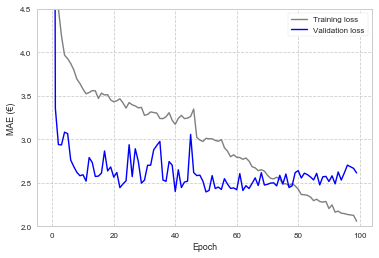

Checkpoint Ensembling

Training model # 2
Epoch 1/100
280/280 [==============================] - 13s 45ms/step - loss: 11.7953 - mean_squared_error: 314.1007 - val_loss: 1.3423 - val_mean_squared_error: 2.8882
Epoch 2/100
280/280 [==============================] - 8s 29ms/step - loss: 1.2640 - mean_squared_error: 5.1072 - val_loss: 0.2431 - val_mean_squared_error: 0.2276
Epoch 3/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3265 - mean_squared_error: 0.2917 - val_loss: 0.2191 - val_mean_squared_error: 0.2030
Epoch 4/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3041 - mean_squared_error: 0.2361 - val_loss: 0.2094 - val_mean_squared_error: 0.1620
Epoch 5/100
280/280 [==============================] - 8s 29ms/step - loss: 0.2948 - mean_squared_error: 0.2360 - val_loss: 0.2106 - val_mean_squared_error: 0.1640
Epoch 6/100
280/280 [==============================] - 8s 29ms/step - loss: 0.2868 - mean_squared_error: 0.2189 - val_loss: 0.1994 - v

Epoch 98/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1648 - mean_squared_error: 0.0778 - val_loss: 0.1925 - val_mean_squared_error: 0.1179
Epoch 99/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1635 - mean_squared_error: 0.0781 - val_loss: 0.1944 - val_mean_squared_error: 0.1172
Epoch 100/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1630 - mean_squared_error: 0.0756 - val_loss: 0.1972 - val_mean_squared_error: 0.1223
Saving model topology and training history plots.


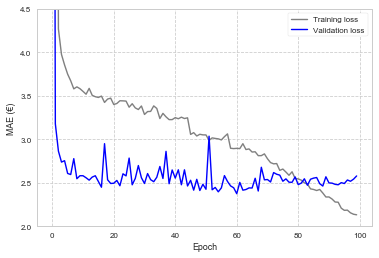

Checkpoint Ensembling

Training model # 3
Epoch 1/100
280/280 [==============================] - 15s 53ms/step - loss: 11.3788 - mean_squared_error: 292.8006 - val_loss: 0.8298 - val_mean_squared_error: 1.2037
Epoch 2/100
280/280 [==============================] - 8s 29ms/step - loss: 1.1927 - mean_squared_error: 4.6515 - val_loss: 0.2355 - val_mean_squared_error: 0.2177
Epoch 3/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3300 - mean_squared_error: 0.2895 - val_loss: 0.2129 - val_mean_squared_error: 0.1777
Epoch 4/100
280/280 [==============================] - 8s 29ms/step - loss: 0.3085 - mean_squared_error: 0.2570 - val_loss: 0.2147 - val_mean_squared_error: 0.1738
Epoch 5/100
280/280 [==============================] - 8s 29ms/step - loss: 0.2934 - mean_squared_error: 0.2325 - val_loss: 0.2096 - val_mean_squared_error: 0.1635
Epoch 6/100
280/280 [==============================] - 8s 29ms/step - loss: 0.2814 - mean_squared_error: 0.2058 - val_loss: 0.2002 - v

Epoch 98/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1675 - mean_squared_error: 0.0733 - val_loss: 0.1996 - val_mean_squared_error: 0.1294
Epoch 99/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1646 - mean_squared_error: 0.0712 - val_loss: 0.1943 - val_mean_squared_error: 0.1208
Epoch 100/100
280/280 [==============================] - 8s 29ms/step - loss: 0.1670 - mean_squared_error: 0.0773 - val_loss: 0.1941 - val_mean_squared_error: 0.1195
Saving model topology and training history plots.


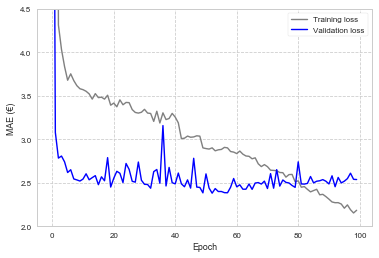

Checkpoint Ensembling

Training model # 4
Epoch 1/100
280/280 [==============================] - 18s 63ms/step - loss: 12.9582 - mean_squared_error: 386.3560 - val_loss: 1.0608 - val_mean_squared_error: 2.0458
Epoch 2/100
280/280 [==============================] - 8s 30ms/step - loss: 1.6637 - mean_squared_error: 7.9753 - val_loss: 0.2682 - val_mean_squared_error: 0.2675
Epoch 3/100
280/280 [==============================] - 9s 30ms/step - loss: 0.3372 - mean_squared_error: 0.3055 - val_loss: 0.2653 - val_mean_squared_error: 0.2324
Epoch 4/100
280/280 [==============================] - 8s 30ms/step - loss: 0.3065 - mean_squared_error: 0.2552 - val_loss: 0.2084 - val_mean_squared_error: 0.1668
Epoch 5/100
280/280 [==============================] - 8s 30ms/step - loss: 0.2920 - mean_squared_error: 0.2323 - val_loss: 0.2182 - val_mean_squared_error: 0.1795
Epoch 6/100
280/280 [==============================] - 8s 30ms/step - loss: 0.2916 - mean_squared_error: 0.2320 - val_loss: 0.2022 - v

Epoch 96/100
280/280 [==============================] - 8s 30ms/step - loss: 0.1679 - mean_squared_error: 0.0785 - val_loss: 0.1957 - val_mean_squared_error: 0.1245
Epoch 97/100
280/280 [==============================] - 8s 30ms/step - loss: 0.1671 - mean_squared_error: 0.0759 - val_loss: 0.1981 - val_mean_squared_error: 0.1222
Epoch 98/100
280/280 [==============================] - 8s 30ms/step - loss: 0.1662 - mean_squared_error: 0.0770 - val_loss: 0.1983 - val_mean_squared_error: 0.1277
Epoch 99/100
280/280 [==============================] - 8s 30ms/step - loss: 0.1653 - mean_squared_error: 0.0799 - val_loss: 0.1954 - val_mean_squared_error: 0.1229
Epoch 100/100
280/280 [==============================] - 8s 30ms/step - loss: 0.1629 - mean_squared_error: 0.0680 - val_loss: 0.2032 - val_mean_squared_error: 0.1292
Saving model topology and training history plots.


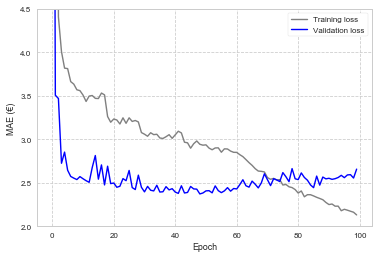

Checkpoint Ensembling

Training model # 5
Epoch 1/100
280/280 [==============================] - 19s 68ms/step - loss: 13.4711 - mean_squared_error: 411.7364 - val_loss: 1.5928 - val_mean_squared_error: 3.4941
Epoch 2/100
280/280 [==============================] - 8s 30ms/step - loss: 1.6649 - mean_squared_error: 8.5246 - val_loss: 0.2377 - val_mean_squared_error: 0.2227
Epoch 3/100
280/280 [==============================] - 9s 31ms/step - loss: 0.3248 - mean_squared_error: 0.2685 - val_loss: 0.2152 - val_mean_squared_error: 0.1849
Epoch 4/100
280/280 [==============================] - 9s 30ms/step - loss: 0.3061 - mean_squared_error: 0.2487 - val_loss: 0.2064 - val_mean_squared_error: 0.1638
Epoch 5/100
280/280 [==============================] - 9s 30ms/step - loss: 0.2917 - mean_squared_error: 0.2448 - val_loss: 0.1981 - val_mean_squared_error: 0.1491
Epoch 6/100
280/280 [==============================] - 9s 30ms/step - loss: 0.2887 - mean_squared_error: 0.2301 - val_loss: 0.2105 - v

280/280 [==============================] - 9s 30ms/step - loss: 0.1855 - mean_squared_error: 0.0986 - val_loss: 0.1881 - val_mean_squared_error: 0.1127
Epoch 98/100
280/280 [==============================] - 9s 30ms/step - loss: 0.1830 - mean_squared_error: 0.0901 - val_loss: 0.1966 - val_mean_squared_error: 0.1219
Epoch 99/100
280/280 [==============================] - 9s 30ms/step - loss: 0.1817 - mean_squared_error: 0.0910 - val_loss: 0.1998 - val_mean_squared_error: 0.1230
Epoch 100/100
280/280 [==============================] - 9s 30ms/step - loss: 0.1773 - mean_squared_error: 0.0854 - val_loss: 0.1946 - val_mean_squared_error: 0.1165
Saving model topology and training history plots.


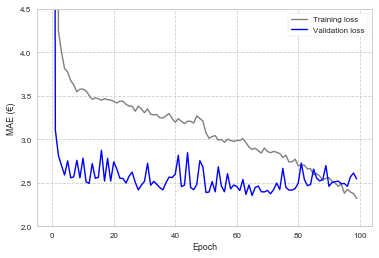

Checkpoint Ensembling


In [8]:
modelnum = 'mlp_1'
path = 'Results - Valid/MLP_1/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

results_1 = evaluate_mlp(mlp_1, layer_x, train_gen, train_steps, stdevs, val_gen, val_steps, test_gen, test_steps,
                         path, k = 5, epochs = 100, ce_k = 5)

In [10]:
# Print the 10 best epochs for each model so we can manually delete the other weights
for i in range(5):
    print(results_1["val_ranked_epochs"][i][0:10])

[51 41 63 52 61 56 54 65 59 60]
[61 55 68 49 63 47 53 64 51 66]
[53 50 58 57 55 56 66 63 64 54]
[49 42 50 44 53 56 45 41 36 31]
[66 64 72 51 52 70 54 69 57 62]


In [24]:
lookback = 12
batch_size = 128

val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)

val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size

path = 'Results - Valid/MLP_1/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

evaluate_results(mlp_1, path)

VALIDATION
+-------+--------------+---------------+------------+-------------+
| Model | Min. MAE (€) | Ass. RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+--------------+---------------+------------+-------------+
|   1   |    2.3942    |     4.4517    |   2.3623   |    4.4401   |
|   2   |    2.3738    |     4.4256    |   2.3642   |    4.4196   |
|   3   |    2.3797    |     4.4474    |   2.3636   |    4.4267   |
|   4   |    2.3710    |     4.4964    |   2.3654   |    4.4788   |
|   5   |    2.3530    |     4.4014    |   2.3403   |    4.4190   |
+-------+--------------+---------------+------------+-------------+
Ensembling across
MAE  (€): 2.3390
RMSE (€): 4.4135
TEST
+-------+----------+-----------+------------+-------------+
| Model |  MAE (€) |  RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+----------+-----------+------------+-------------+
|   1   |  2.7122  |   4.7409  |   2.6922   |    4.6670   |
|   2   |  2.6793  |   4.7478  |   2.6894   |    4.7581   |
|   3   |  2.7477  |

## MLP 2
### ResNet-esque
- 12 hours
- Residual connections between stacks
- Residual connections from raw (flattened) inputs to the end of each stack
- Glorot Uniform Weight initialization
- 6x3 stacks
- Dropout after residual connections and layer output have been added together  
  
The difference between this network and ResNets (from the paper) is that the latter does not have residual connections to the raw input, contrary to our model. We get much better results by including these. We also do not use bias for our shortcut connections, whereas it's unclear if they do. We might also have gotten the identity functions completely wrong, e.g. doing Dense(512, use_bias = False) could be completely wrong (though this is what Chollet suggests).

In [26]:
def mlp_2(input_layer):
    layer_1 = layers.Flatten(input_shape = (lookback+1, df2n.shape[-1]-1))(input_layer)

    layer_2 = layers.BatchNormalization()(layer_1)
    layer_2 = layers.Activation('relu')(layer_2)
    layer_2 = layers.Dense(512, kernel_initializer = 'glorot_uniform')(layer_2)
    layer_3 = layers.BatchNormalization()(layer_2)
    layer_3 = layers.Activation('relu')(layer_3)
    layer_3 = layers.Dense(512, kernel_initializer = 'glorot_uniform')(layer_3)
    layer_4 = layers.BatchNormalization()(layer_3)
    layer_4 = layers.Activation('relu')(layer_4)
    layer_4 = layers.Dense(512, kernel_initializer = 'glorot_uniform')(layer_4)
    residual_1 = layers.Dense(512, use_bias = False)(layer_1)
    layer_5 = layers.add([layer_4, residual_1])
    layer_6 = layers.Dropout(0.5)(layer_5)

    layer_7 = layers.BatchNormalization()(layer_6)
    layer_7 = layers.Activation('relu')(layer_7)
    layer_7 = layers.Dense(256, kernel_initializer = 'glorot_uniform')(layer_7)
    layer_8 = layers.BatchNormalization()(layer_7)
    layer_8 = layers.Activation('relu')(layer_8)
    layer_8 = layers.Dense(256, kernel_initializer = 'glorot_uniform')(layer_8)
    layer_9 = layers.BatchNormalization()(layer_8)
    layer_9 = layers.Activation('relu')(layer_9)
    layer_9 = layers.Dense(256, kernel_initializer = 'glorot_uniform')(layer_9)
    residual_2 = layers.Dense(256, use_bias = False)(layer_6)
    residual_2x = layers.Dense(256, use_bias = False)(layer_1)
    layer_10 = layers.add([layer_9, residual_2, residual_2x])
    layer_11 = layers.Dropout(0.45)(layer_10)

    layer_12 = layers.BatchNormalization()(layer_11)
    layer_12 = layers.Activation('relu')(layer_12)
    layer_12 = layers.Dense(256, kernel_initializer = 'glorot_uniform')(layer_12)
    layer_13 = layers.BatchNormalization()(layer_12)
    layer_13 = layers.Activation('relu')(layer_13)
    layer_13 = layers.Dense(256, kernel_initializer = 'glorot_uniform')(layer_13)
    layer_14 = layers.BatchNormalization()(layer_13)
    layer_14 = layers.Activation('relu')(layer_14)
    layer_14 = layers.Dense(256, kernel_initializer = 'glorot_uniform')(layer_14)
    #residual_3 = layers.Dense(256, use_bias = False)(layer_11)
    residual_3x = layers.Dense(256, use_bias = False)(layer_1)
    layer_15 = layers.add([layer_14, layer_11, residual_3x])
    layer_16 = layers.Dropout(0.45)(layer_15)

    layer_17 = layers.BatchNormalization()(layer_16)
    layer_17 = layers.Activation('relu')(layer_17)
    layer_17 = layers.Dense(128, kernel_initializer = 'glorot_uniform')(layer_17)
    layer_18 = layers.BatchNormalization()(layer_17)
    layer_18 = layers.Activation('relu')(layer_18)
    layer_18 = layers.Dense(128, kernel_initializer = 'glorot_uniform')(layer_18)
    layer_19 = layers.BatchNormalization()(layer_18)
    layer_19 = layers.Activation('relu')(layer_19)
    layer_19 = layers.Dense(128, kernel_initializer = 'glorot_uniform')(layer_19)
    residual_4 = layers.Dense(128, use_bias = False)(layer_16)
    residual_4x = layers.Dense(128, use_bias = False)(layer_1)
    layer_20 = layers.add([layer_19, residual_4, residual_4x])
    layer_21 = layers.Dropout(0.4)(layer_20)

    layer_22 = layers.BatchNormalization()(layer_21)
    layer_22 = layers.Activation('relu')(layer_22)
    layer_22 = layers.Dense(128, kernel_initializer = 'glorot_uniform')(layer_22)
    layer_23 = layers.BatchNormalization()(layer_22)
    layer_23 = layers.Activation('relu')(layer_23)
    layer_23 = layers.Dense(128, kernel_initializer = 'glorot_uniform')(layer_23)
    layer_24 = layers.BatchNormalization()(layer_23)
    layer_24 = layers.Activation('relu')(layer_24)
    layer_24 = layers.Dense(128, kernel_initializer = 'glorot_uniform')(layer_24)
    #residual_5 = layers.Dense(128, use_bias = False)(layer_21)
    residual_5x = layers.Dense(128, use_bias = False)(layer_1)
    layer_25 = layers.add([layer_24, layer_21, residual_5x])
    layer_26 = layers.Dropout(0.4)(layer_25)

    layer_27 = layers.BatchNormalization()(layer_26)
    layer_27 = layers.Activation('relu')(layer_27)
    layer_27 = layers.Dense(64, kernel_initializer = 'glorot_uniform')(layer_27)
    layer_28 = layers.BatchNormalization()(layer_27)
    layer_28 = layers.Activation('relu')(layer_28)
    layer_28 = layers.Dense(64, kernel_initializer = 'glorot_uniform')(layer_28)
    layer_29 = layers.BatchNormalization()(layer_28)
    layer_29 = layers.Activation('relu')(layer_29)
    layer_29 = layers.Dense(64, kernel_initializer = 'glorot_uniform')(layer_29)
    residual_6 = layers.Dense(64, use_bias = False)(layer_26)
    residual_6x = layers.Dense(64, use_bias = False)(layer_1)
    layer_30 = layers.add([layer_29, residual_6, residual_6x])
    layer_31 = layers.Dropout(0.3)(layer_30)

    output_layer = layers.Dense(1)(layer_31)

    model = Model(input_layer, output_layer)
    
    return model

**Evaluate Train vs. Validation**  
Train 5 models with different random weight initializations so that we can take the median performance for a more reliable estimate of model performance. For each model, return the MAE and RMSE on the validation data. Also use the five best checkpoints (i.e. weights of the five lowest validation losses during training) to make a checkpoint ensemble, and return the resulting validation set MAE and RMSE.

In [7]:
lookback = 12
batch_size = 128

train_gen = generator(df2n, lookback=lookback, max_index=train_size, shuffle=True, batch_size=batch_size)
val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size, batch_size=batch_size)
test_gen = generator(df2n, lookback=lookback, min_index=train_size+valid_size+1, batch_size=batch_size)

train_steps = (train_size - lookback) // batch_size
val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size


Training model # 1
Epoch 1/100
280/280 [==============================] - 35s 124ms/step - loss: 12.3026 - mean_squared_error: 350.5397 - val_loss: 0.8690 - val_mean_squared_error: 1.3083
Epoch 2/100
280/280 [==============================] - 12s 44ms/step - loss: 1.4495 - mean_squared_error: 6.4021 - val_loss: 0.2457 - val_mean_squared_error: 0.2328
Epoch 3/100
280/280 [==============================] - 12s 44ms/step - loss: 0.3331 - mean_squared_error: 0.2939 - val_loss: 0.2276 - val_mean_squared_error: 0.1998
Epoch 4/100
280/280 [==============================] - 12s 44ms/step - loss: 0.3137 - mean_squared_error: 0.2709 - val_loss: 0.2097 - val_mean_squared_error: 0.1744
Epoch 5/100
280/280 [==============================] - 12s 44ms/step - loss: 0.2959 - mean_squared_error: 0.2387 - val_loss: 0.2155 - val_mean_squared_error: 0.1544
Epoch 6/100
280/280 [==============================] - 12s 44ms/step - loss: 0.2930 - mean_squared_error: 0.2342 - val_loss: 0.2038 - val_mean_squared_

280/280 [==============================] - 13s 45ms/step - loss: 0.1322 - mean_squared_error: 0.0489 - val_loss: 0.2199 - val_mean_squared_error: 0.1325
Epoch 98/100
280/280 [==============================] - 12s 45ms/step - loss: 0.1318 - mean_squared_error: 0.0505 - val_loss: 0.2018 - val_mean_squared_error: 0.1250
Epoch 99/100
280/280 [==============================] - 13s 45ms/step - loss: 0.1284 - mean_squared_error: 0.0426 - val_loss: 0.2174 - val_mean_squared_error: 0.1280
Epoch 100/100
280/280 [==============================] - 13s 45ms/step - loss: 0.1286 - mean_squared_error: 0.0471 - val_loss: 0.2065 - val_mean_squared_error: 0.1262
Saving model topology and training history plots.


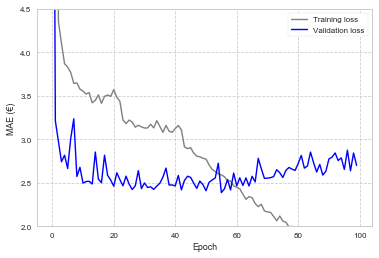

Checkpoint Ensembling

Training model # 2
Epoch 1/100
280/280 [==============================] - 40s 141ms/step - loss: 11.5083 - mean_squared_error: 313.6536 - val_loss: 0.7013 - val_mean_squared_error: 0.9597
Epoch 2/100
280/280 [==============================] - 13s 46ms/step - loss: 1.3049 - mean_squared_error: 5.5247 - val_loss: 0.2450 - val_mean_squared_error: 0.2410
Epoch 3/100
280/280 [==============================] - 13s 47ms/step - loss: 0.3227 - mean_squared_error: 0.2778 - val_loss: 0.2135 - val_mean_squared_error: 0.1748
Epoch 4/100
280/280 [==============================] - 13s 47ms/step - loss: 0.2983 - mean_squared_error: 0.2372 - val_loss: 0.2056 - val_mean_squared_error: 0.1650
Epoch 5/100
280/280 [==============================] - 13s 48ms/step - loss: 0.2925 - mean_squared_error: 0.2347 - val_loss: 0.1984 - val_mean_squared_error: 0.1511
Epoch 6/100
280/280 [==============================] - 13s 47ms/step - loss: 0.2808 - mean_squared_error: 0.2038 - val_loss: 0.19

280/280 [==============================] - 13s 46ms/step - loss: 0.2319 - mean_squared_error: 0.1510 - val_loss: 0.1849 - val_mean_squared_error: 0.1198
Epoch 50/100
280/280 [==============================] - 13s 47ms/step - loss: 0.2302 - mean_squared_error: 0.1515 - val_loss: 0.2058 - val_mean_squared_error: 0.1282
Epoch 51/100
280/280 [==============================] - 13s 47ms/step - loss: 0.2324 - mean_squared_error: 0.1511 - val_loss: 0.2129 - val_mean_squared_error: 0.1360
Epoch 52/100
280/280 [==============================] - 13s 46ms/step - loss: 0.2300 - mean_squared_error: 0.1452 - val_loss: 0.1969 - val_mean_squared_error: 0.1269
Epoch 53/100
280/280 [==============================] - 13s 47ms/step - loss: 0.2317 - mean_squared_error: 0.1512 - val_loss: 0.1870 - val_mean_squared_error: 0.1220
Epoch 54/100
280/280 [==============================] - 13s 46ms/step - loss: 0.2296 - mean_squared_error: 0.1496 - val_loss: 0.1873 - val_mean_squared_error: 0.1269
Epoch 55/100
280/

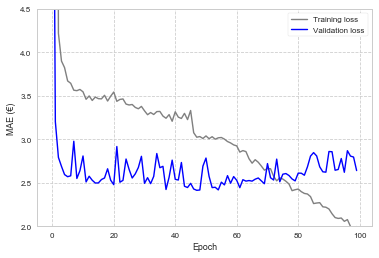

Checkpoint Ensembling

Training model # 3
Epoch 1/100
280/280 [==============================] - 45s 161ms/step - loss: 13.2787 - mean_squared_error: 408.6247 - val_loss: 0.9612 - val_mean_squared_error: 1.6648
Epoch 2/100
280/280 [==============================] - 13s 47ms/step - loss: 1.6821 - mean_squared_error: 8.7464 - val_loss: 0.2778 - val_mean_squared_error: 0.2699
Epoch 3/100
280/280 [==============================] - 13s 47ms/step - loss: 0.3367 - mean_squared_error: 0.2970 - val_loss: 0.2543 - val_mean_squared_error: 0.2326
Epoch 4/100
280/280 [==============================] - 13s 47ms/step - loss: 0.3174 - mean_squared_error: 0.2650 - val_loss: 0.2099 - val_mean_squared_error: 0.1575
Epoch 5/100
280/280 [==============================] - 13s 47ms/step - loss: 0.3025 - mean_squared_error: 0.2412 - val_loss: 0.2093 - val_mean_squared_error: 0.1692
Epoch 6/100
280/280 [==============================] - 13s 47ms/step - loss: 0.2954 - mean_squared_error: 0.2443 - val_loss: 0.21

280/280 [==============================] - 13s 46ms/step - loss: 0.1684 - mean_squared_error: 0.0708 - val_loss: 0.2156 - val_mean_squared_error: 0.1479
Epoch 100/100
280/280 [==============================] - 13s 46ms/step - loss: 0.1623 - mean_squared_error: 0.0662 - val_loss: 0.2068 - val_mean_squared_error: 0.1238
Saving model topology and training history plots.


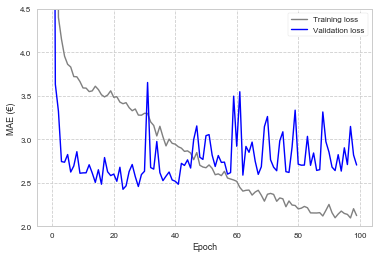

Checkpoint Ensembling

Training model # 4
Epoch 1/100
280/280 [==============================] - 51s 183ms/step - loss: 13.5150 - mean_squared_error: 423.7071 - val_loss: 0.8581 - val_mean_squared_error: 1.3481
Epoch 2/100
280/280 [==============================] - 14s 49ms/step - loss: 1.6934 - mean_squared_error: 8.9004 - val_loss: 0.2457 - val_mean_squared_error: 0.2337
Epoch 3/100
280/280 [==============================] - 14s 50ms/step - loss: 0.3344 - mean_squared_error: 0.2956 - val_loss: 0.2188 - val_mean_squared_error: 0.1972
Epoch 4/100
280/280 [==============================] - 14s 50ms/step - loss: 0.3062 - mean_squared_error: 0.2583 - val_loss: 0.2056 - val_mean_squared_error: 0.1595
Epoch 5/100
280/280 [==============================] - 14s 50ms/step - loss: 0.2961 - mean_squared_error: 0.2384 - val_loss: 0.2015 - val_mean_squared_error: 0.1553
Epoch 6/100
280/280 [==============================] - 14s 50ms/step - loss: 0.2886 - mean_squared_error: 0.2178 - val_loss: 0.20

280/280 [==============================] - 14s 50ms/step - loss: 0.1486 - mean_squared_error: 0.0575 - val_loss: 0.2184 - val_mean_squared_error: 0.1273
Epoch 99/100
280/280 [==============================] - 14s 50ms/step - loss: 0.1471 - mean_squared_error: 0.0555 - val_loss: 0.1984 - val_mean_squared_error: 0.1215
Epoch 100/100
280/280 [==============================] - 14s 50ms/step - loss: 0.1551 - mean_squared_error: 0.0617 - val_loss: 0.2085 - val_mean_squared_error: 0.1360
Saving model topology and training history plots.


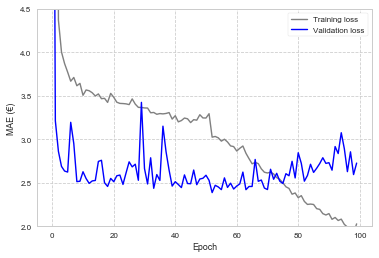

Checkpoint Ensembling

Training model # 5
Epoch 1/100
280/280 [==============================] - 58s 206ms/step - loss: 13.7503 - mean_squared_error: 438.9974 - val_loss: 1.0042 - val_mean_squared_error: 1.6982
Epoch 2/100
280/280 [==============================] - 15s 52ms/step - loss: 1.7773 - mean_squared_error: 9.3338 - val_loss: 0.2864 - val_mean_squared_error: 0.2779
Epoch 3/100
280/280 [==============================] - 15s 52ms/step - loss: 0.3310 - mean_squared_error: 0.2914 - val_loss: 0.2161 - val_mean_squared_error: 0.1773
Epoch 4/100
280/280 [==============================] - 15s 52ms/step - loss: 0.3131 - mean_squared_error: 0.2789 - val_loss: 0.2180 - val_mean_squared_error: 0.1790
Epoch 5/100
280/280 [==============================] - 15s 52ms/step - loss: 0.2965 - mean_squared_error: 0.2345 - val_loss: 0.2159 - val_mean_squared_error: 0.1726
Epoch 6/100
280/280 [==============================] - 15s 52ms/step - loss: 0.2868 - mean_squared_error: 0.2203 - val_loss: 0.21

280/280 [==============================] - 15s 52ms/step - loss: 0.2254 - mean_squared_error: 0.1476 - val_loss: 0.1887 - val_mean_squared_error: 0.1213
Epoch 50/100
280/280 [==============================] - 15s 52ms/step - loss: 0.2193 - mean_squared_error: 0.1300 - val_loss: 0.1996 - val_mean_squared_error: 0.1256
Epoch 51/100
280/280 [==============================] - 15s 52ms/step - loss: 0.2196 - mean_squared_error: 0.1374 - val_loss: 0.1953 - val_mean_squared_error: 0.1185
Epoch 52/100
280/280 [==============================] - 15s 52ms/step - loss: 0.2157 - mean_squared_error: 0.1254 - val_loss: 0.1896 - val_mean_squared_error: 0.1210
Epoch 53/100
280/280 [==============================] - 15s 52ms/step - loss: 0.2152 - mean_squared_error: 0.1239 - val_loss: 0.1937 - val_mean_squared_error: 0.1214
Epoch 54/100
280/280 [==============================] - 15s 52ms/step - loss: 0.2142 - mean_squared_error: 0.1201 - val_loss: 0.1920 - val_mean_squared_error: 0.1145
Epoch 55/100
280/

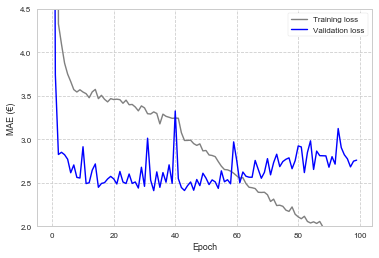

Checkpoint Ensembling


In [15]:
path = 'Results - Valid/MLP_2/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

results_2 = evaluate_mlp(mlp_2, layer_x, train_gen, train_steps, stdevs, val_gen, val_steps, test_gen, test_steps,
                         path, k = 5, epochs = 100, ce_k = 5)

In [17]:
# Print the 10 best epochs for each model so we can manually delete the other weights
for i in range(5):
    print(results_2["val_ranked_epochs"][i][0:10])

[56 51 59 43 27 34 57 30 48 32]
[48 49 55 38 47 62 53 45 54 44]
[24 29 25 42 17 15 22 41 37 40]
[53 64 56 71 60 34 70 43 58 55]
[34 44 47 55 29 43 36 16 31 45]


In [27]:
lookback = 12
batch_size = 128

val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size

path = 'Results - Valid/MLP_2/'
layer_x = Input(shape = (lookback+1, df2n.shape[-1]-1))

evaluate_results(mlp_2, path)

VALIDATION
+-------+--------------+---------------+------------+-------------+
| Model | Min. MAE (€) | Ass. RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+--------------+---------------+------------+-------------+
|   1   |    2.3863    |     4.3225    |   2.3476   |    4.3791   |
|   2   |    2.4126    |     4.4930    |   2.3699   |    4.4675   |
|   3   |    2.4244    |     4.5616    |   2.3440   |    4.4171   |
|   4   |    2.3864    |     4.4851    |   2.3606   |    4.4284   |
|   5   |    2.4089    |     4.5622    |   2.3549   |    4.4701   |
+-------+--------------+---------------+------------+-------------+
Ensembling across
MAE  (€): 2.3411
RMSE (€): 4.4246

TEST
+-------+----------+-----------+------------+-------------+
| Model |  MAE (€) |  RMSE (€) | CE MAE (€) | CE RMSE (€) |
+-------+----------+-----------+------------+-------------+
|   1   |  2.7721  |   4.6800  |   2.6972   |    4.7074   |
|   2   |  2.7029  |   4.7459  |   2.6776   |    4.7783   |
|   3   |  2.7446  